# Time Series Analysis

In [1]:
# Load the Dataframe from Nootbook 01 and 02

%store -r daily_data_df df

In [2]:
# Data handling

import pandas as pd
import numpy as np

# Plotting

import matplotlib.pyplot as plt
import seaborn as sns


cmaps_hex = ['#193251','#FF5A36','#1E4485', '#99D04A','#FF5A36', '#DB6668']
sns.set_palette(palette=cmaps_hex)
sns_c = sns.color_palette(palette=cmaps_hex)

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'})


# Time Series

from scipy.ndimage import gaussian_filter
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.formula.api as smf
import statsmodels.api as sm



### Smoothing

Usually the first question of data analysis is "Can we extract general, global pattern here?". 
In time series with seasonal trend variation, 
this means that we want to smooth out this seasonality and let the global trend manifest itself. Most commonly, the first step for this is
smoothing by using Moving Average.

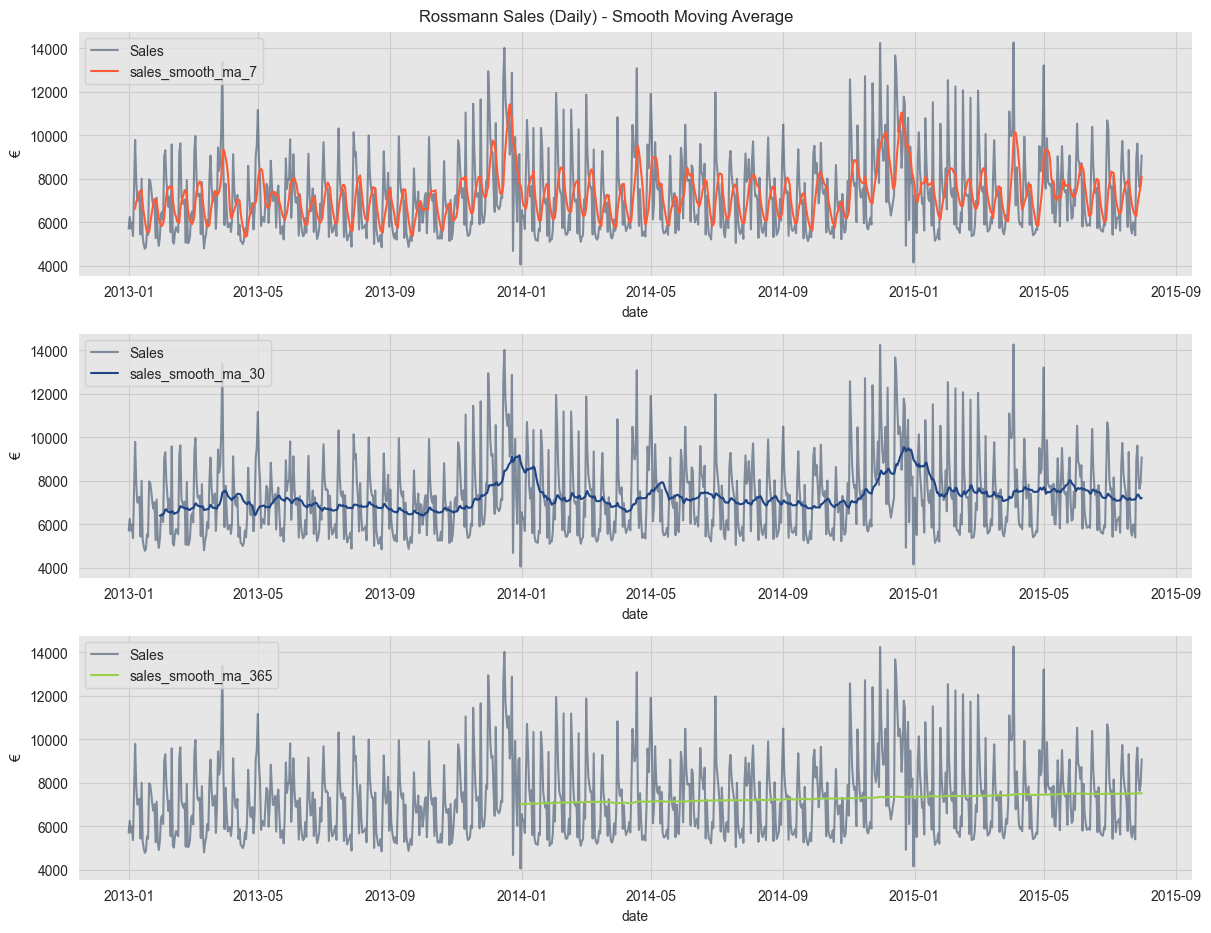

In [3]:
# Plot moving average of different length (week, month, year)

ma = [7, 30, 365]

smooth_daily_data_df = daily_data_df \
    .reset_index() \
    .assign(date = lambda x: x['timestamp'].transform(pd.to_datetime))

# Smooth and plot

fig, ax = plt.subplots(3, 1, figsize=(12, 9), constrained_layout=True)

for i, m in enumerate(ma):

    smooth_daily_data_df[f'sales_smooth_ma_{m}'] = smooth_daily_data_df['sales'].rolling(window=m).mean()

    sns.lineplot(x='date', y='sales', label='Sales', data=smooth_daily_data_df, alpha=0.5, ax=ax[i])
    sns.lineplot(x='date', y=f'sales_smooth_ma_{m}', label=f'sales_smooth_ma_{m}', data=smooth_daily_data_df, color=sns_c[i + 1], ax=ax[i])
    ax[i].legend(loc='upper left')
    ax[i].set(title='', ylabel="€");

plt.suptitle('Rossmann Sales (Daily) - Smooth Moving Average', y=1.02);

Using the moving average of 365 units relfects the yearly structure of the data (lowest panel in the plot above).

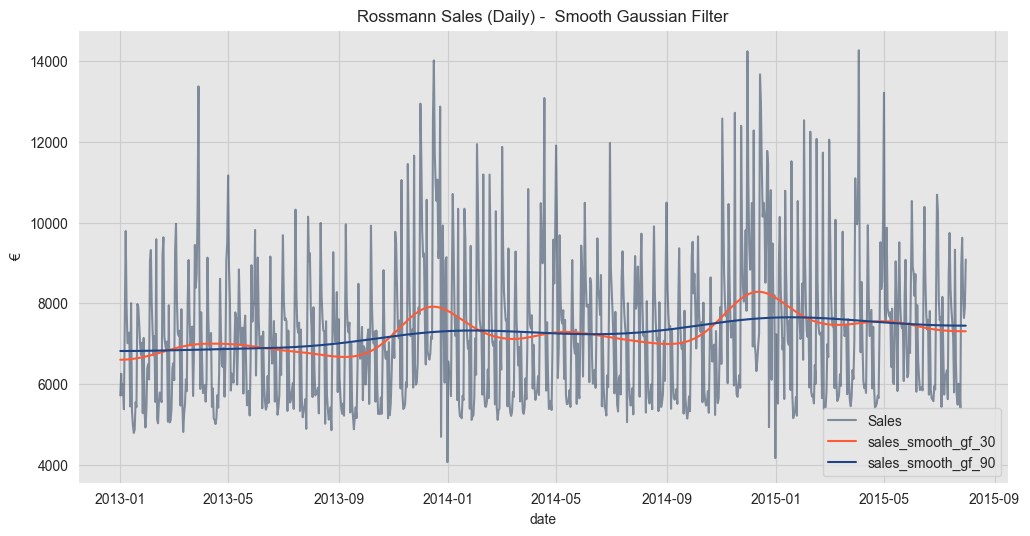

In [5]:
# Smooth data with gaussion filter

smooth_daily_data_df = smooth_daily_data_df \
    .assign(sales_smooth_gf_30 = lambda x: gaussian_filter(input=x['sales'], sigma=30)) \
    .assign(sales_smooth_gf_90 = lambda x: gaussian_filter(input=x['sales'], sigma=90))

# Plot data
fig, ax = plt.subplots()
sns.lineplot(x='date', y='sales', label='Sales', data=smooth_daily_data_df, alpha=0.5, ax=ax)
sns.lineplot(x='date', y='sales_smooth_gf_30', label='sales_smooth_gf_30', data=smooth_daily_data_df, color=sns_c[1], ax=ax)
sns.lineplot(x='date', y='sales_smooth_gf_90', label='sales_smooth_gf_90', data=smooth_daily_data_df, color=sns_c[2], ax=ax)
ax.legend(loc='lower right')
ax.set(title='Rossmann Sales (Daily) -  Smooth Gaussian Filter', ylabel="€");

Let us use this smoothing to plot again the seasonality yearly Sales:

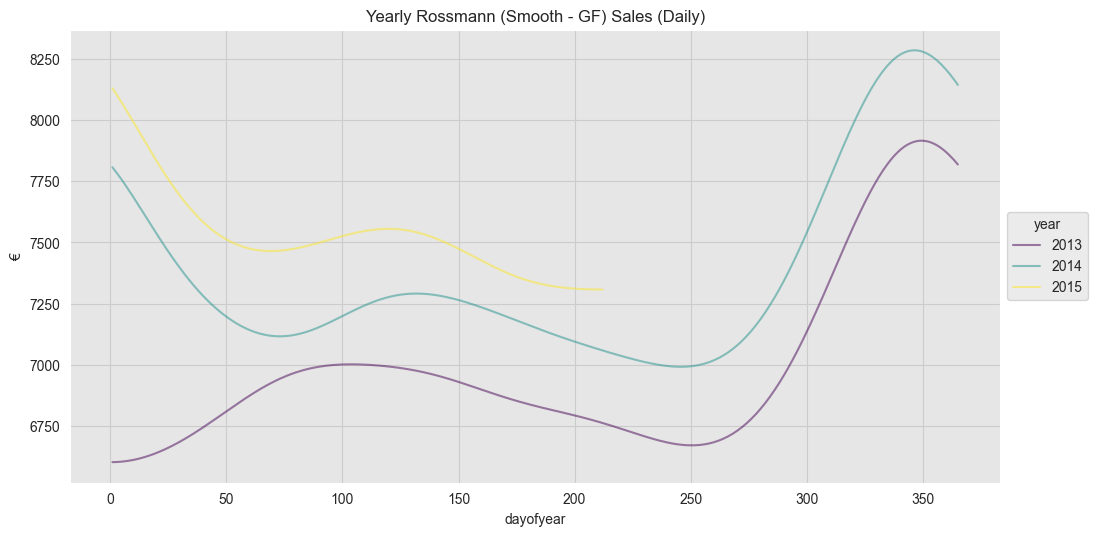

In [6]:
# Plot seasonal yearly sales 

fig, ax = plt.subplots() 

pd.pivot_table(data=smooth_daily_data_df[['year', 'dayofyear', 'sales_smooth_gf_30']], index='dayofyear', columns='year') \
    ['sales_smooth_gf_30'] \
    .plot(cmap='viridis', alpha=0.5, ax=ax)

ax.legend(title='year', loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Yearly Rossmann (Smooth - GF) Sales (Daily)', ylabel="€");

### Time Series Decomposition

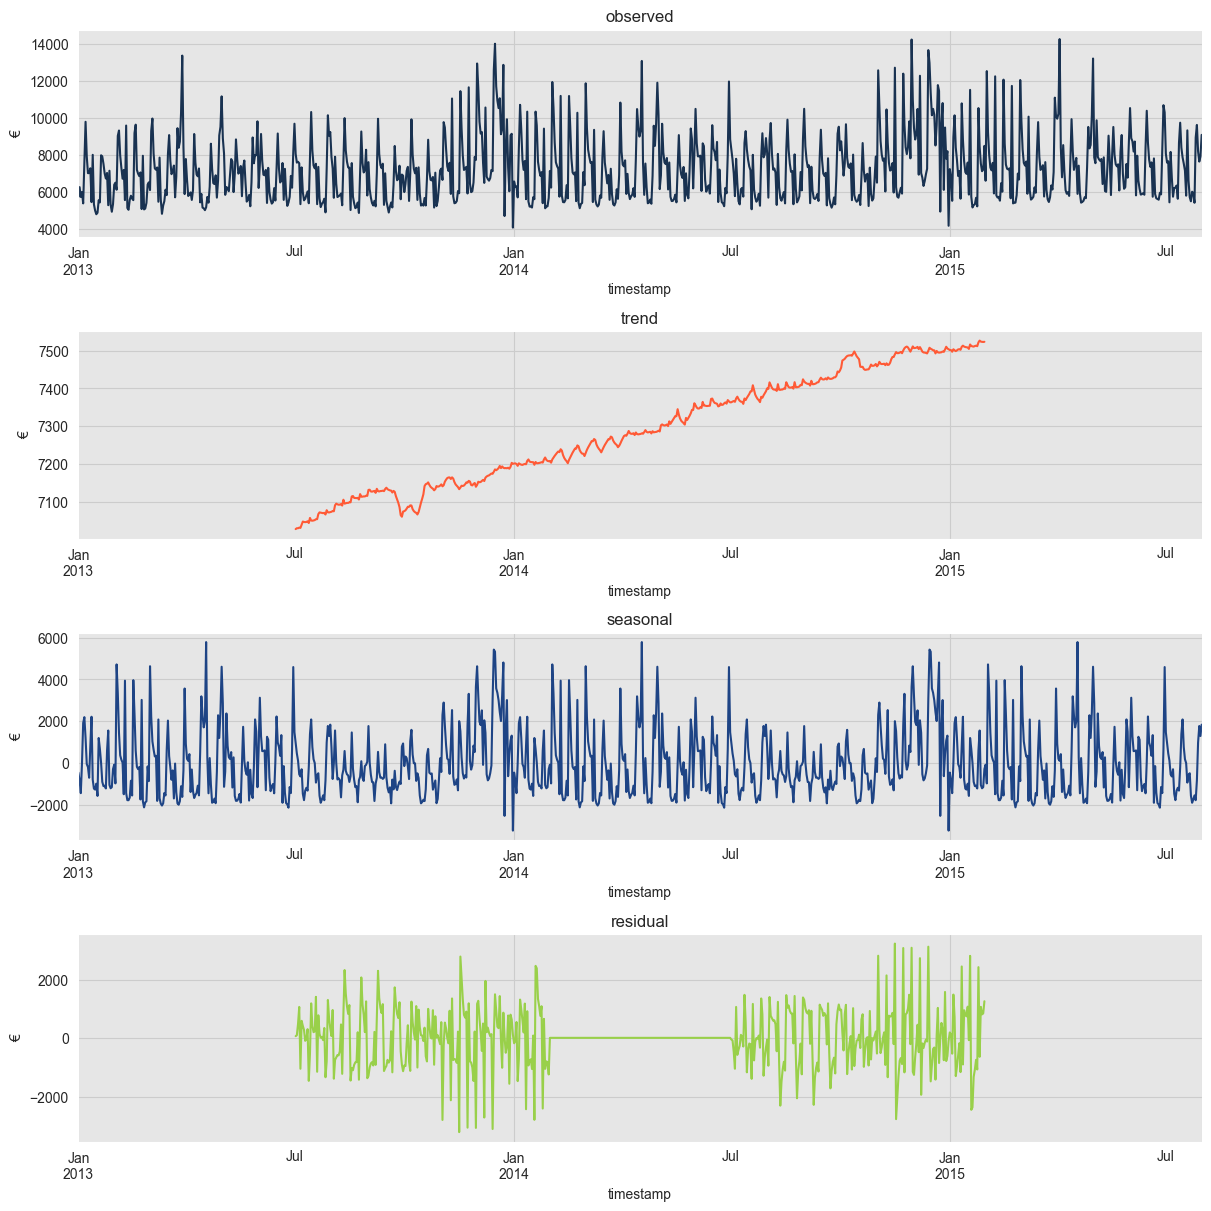

In [8]:
# We use the parameter `period` = 365 to extract the yearly seasonality. 

seas_decomp_yearly = seasonal_decompose(
    x=daily_data_df['sales'], 
    model='additive', 
    period=365
)

# Plot data

fig, ax = plt.subplots(4, 1, figsize=(12, 12), constrained_layout=True)

seas_decomp_yearly.observed.plot(c=sns_c[0], ax=ax[0])
ax[0].set(title='observed', ylabel="€")
seas_decomp_yearly.trend.plot(c=sns_c[1], ax=ax[1])
ax[1].set(title='trend', ylabel="€")
seas_decomp_yearly.seasonal.plot(c=sns_c[2], ax=ax[2])
ax[2].set(title='seasonal', ylabel="€")
seas_decomp_yearly.resid.plot(c=sns_c[3], ax=ax[3])
ax[3].set(title='residual', ylabel="€");

We can now decompose the seasonal component from above. 

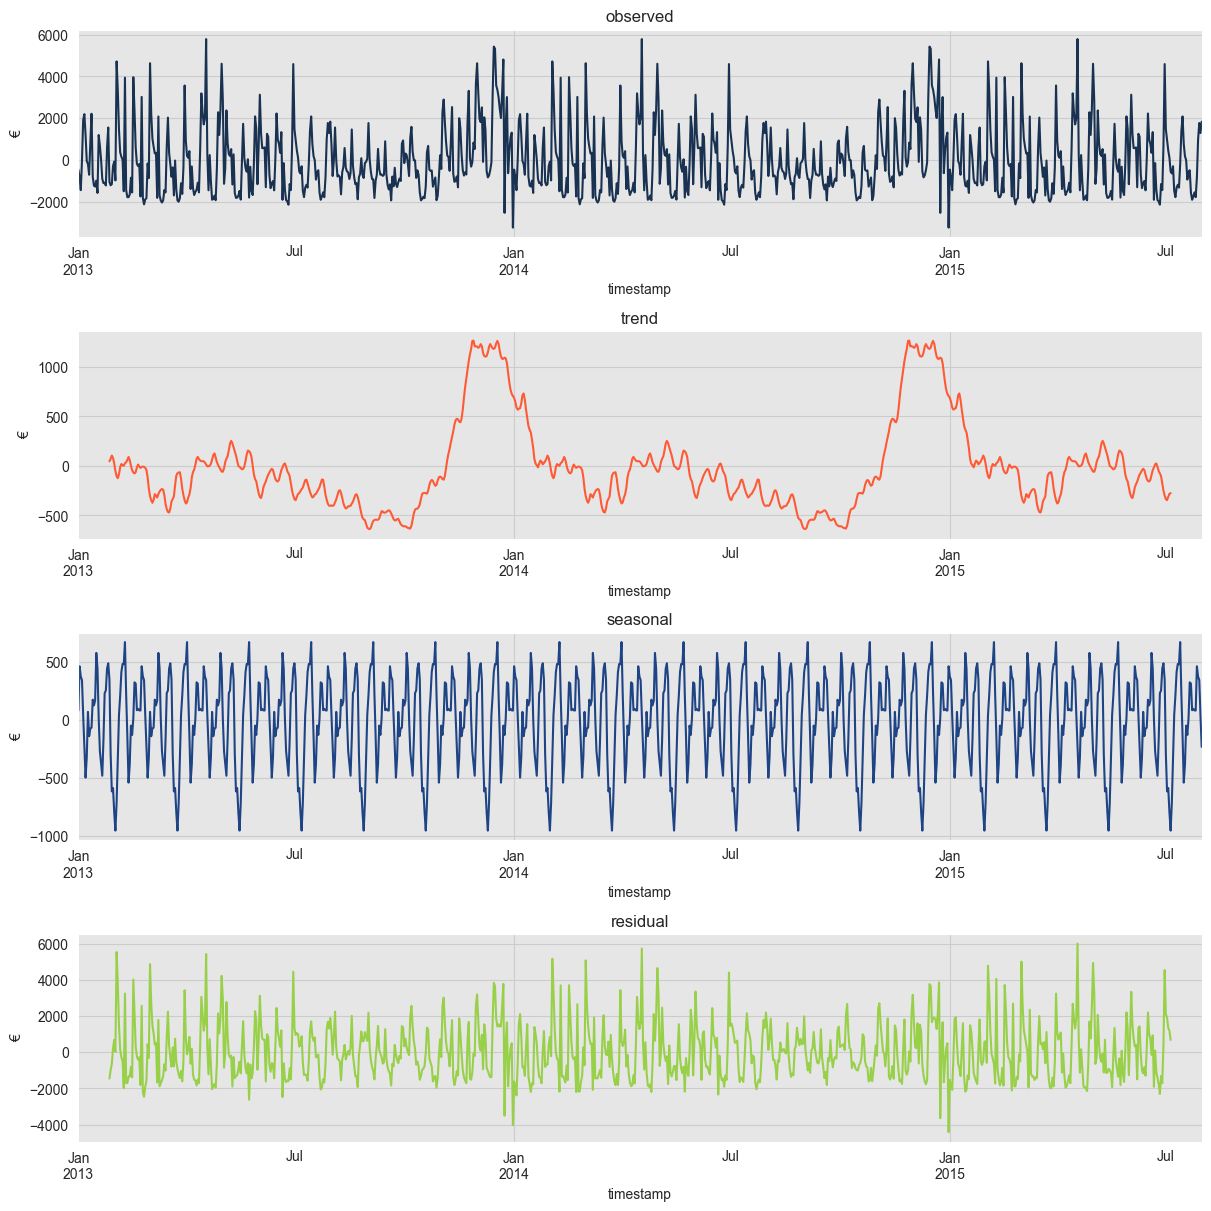

In [9]:
seas_decomp_monthly = seasonal_decompose(
    x=seas_decomp_yearly.seasonal, 
    model='additive', 
    period=52
)

# Plot data
fig, ax = plt.subplots(4, 1, figsize=(12, 12), constrained_layout=True)

seas_decomp_monthly.observed.plot(c=sns_c[0], ax=ax[0])
ax[0].set(title='observed', ylabel="€")
seas_decomp_monthly.trend.plot(c=sns_c[1], ax=ax[1])
ax[1].set(title='trend', ylabel="€")
seas_decomp_monthly.seasonal.plot(c=sns_c[2], ax=ax[2])
ax[2].set(title='seasonal', ylabel="€")
seas_decomp_monthly.resid.plot(c=sns_c[3], ax=ax[3])
ax[3].set(title='residual', ylabel="€");

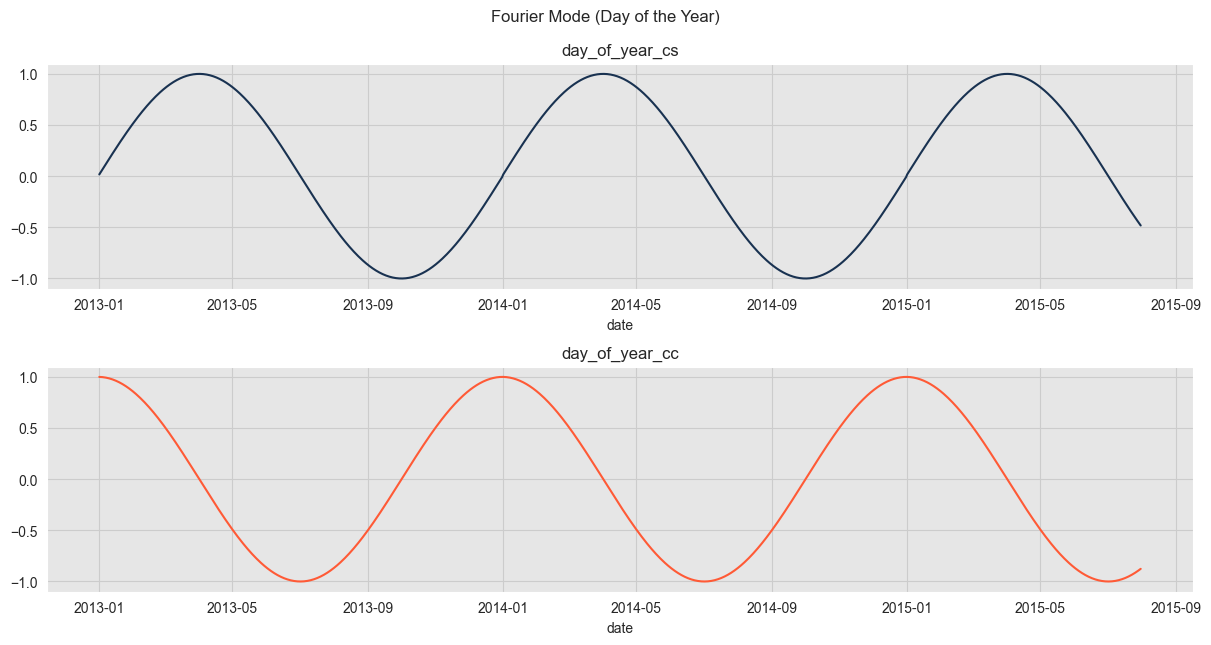

In [11]:
# Create linear trend and cyclical variables to model the day of the year. 

smooth_daily_data_df = smooth_daily_data_df.assign(
    index = lambda x: np.linspace(start=0, stop=x.shape[0]-1, num=x.shape[0]),
    day_of_year_cs = lambda x: np.sin(2*np.pi*x['dayofyear']/365.5),
    day_of_year_cc = lambda x: np.cos(2*np.pi*x['dayofyear']/365.5)
)

# Plot data

fig, ax = plt.subplots(2, 1, constrained_layout=True)
sns.lineplot(x='date', y='day_of_year_cs', data=smooth_daily_data_df, color=sns_c[0], ax=ax[0])
ax[0].set(title='day_of_year_cs', ylabel='')
sns.lineplot(x='date', y='day_of_year_cc', data=smooth_daily_data_df, color=sns_c[1], ax=ax[1])
ax[1].set(title='day_of_year_cc', ylabel='')
plt.suptitle('Fourier Mode (Day of the Year)', y=1.05);

Next, we use a linear model to fit each component:

In [12]:
# Define model

decomp_model = smf.ols(formula = 'sales ~ index + day_of_year_cs + day_of_year_cc', data=smooth_daily_data_df)

# Train model

decomp_red = decomp_model.fit()
print(decomp_red.summary()) 

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     12.93
Date:                Mon, 02 Aug 2021   Prob (F-statistic):           2.77e-08
Time:                        15:22:29   Log-Likelihood:                -8356.5
No. Observations:                 942   AIC:                         1.672e+04
Df Residuals:                     938   BIC:                         1.674e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       6769.7857    113.399     59.

Finally, let us extract each component.

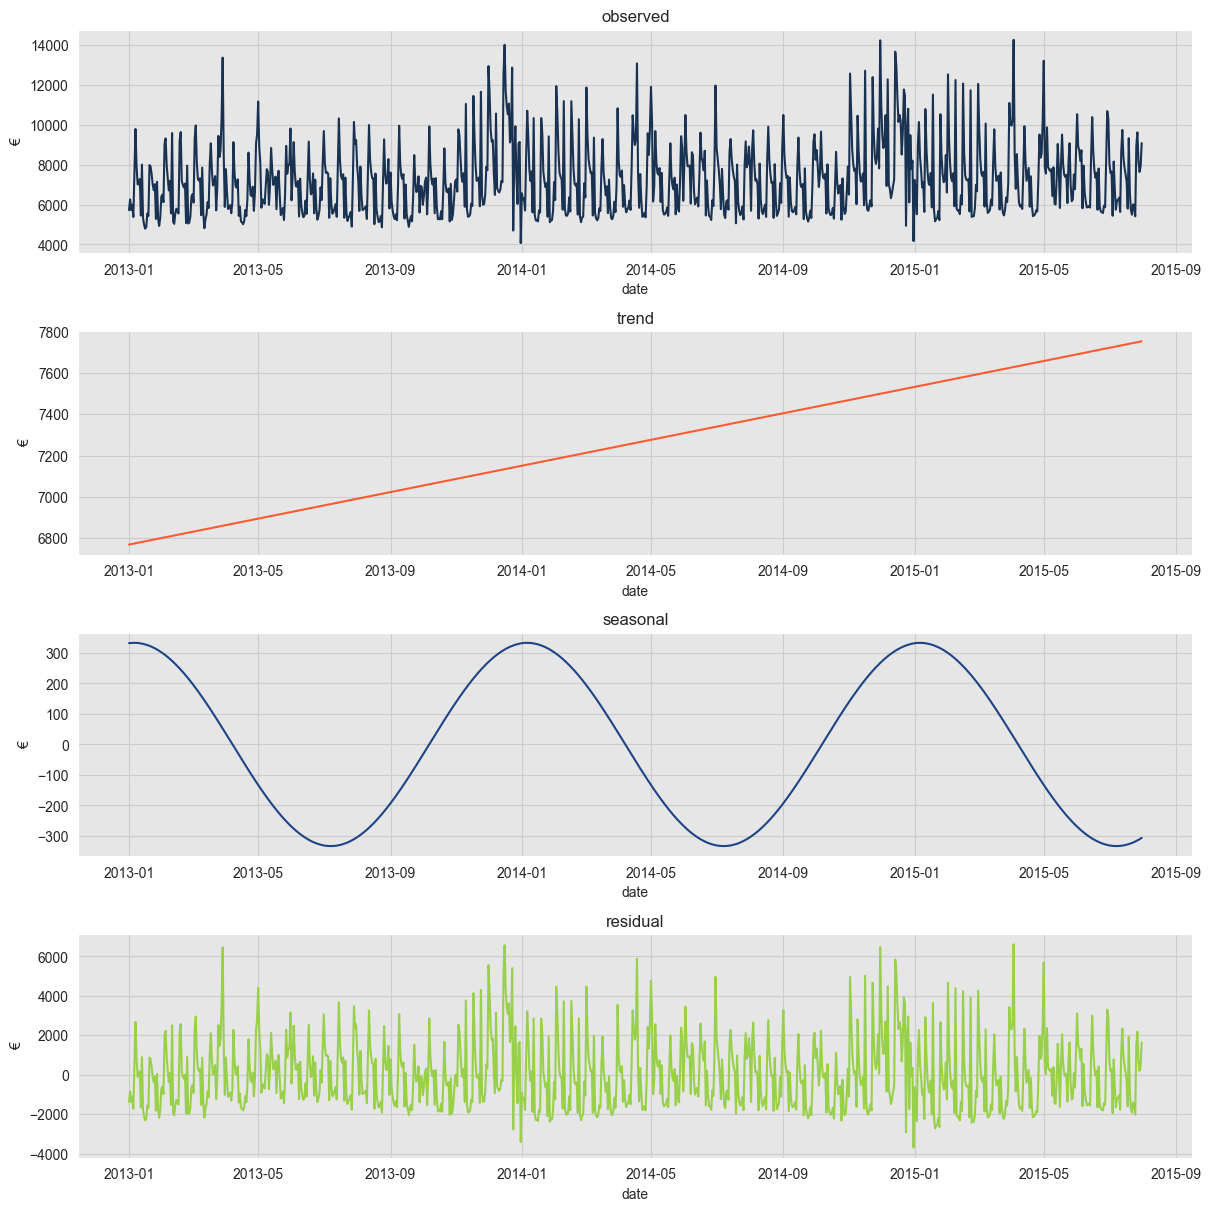

In [13]:
smooth_daily_data_df = smooth_daily_data_df.assign(
    decomp_trend = decomp_red.predict(smooth_daily_data_df.assign(day_of_year_cs = 0.0, day_of_year_cc = 0.0)),
    decomp_seas = decomp_red.predict(smooth_daily_data_df.assign(index = 0.0)) - decomp_red.params['Intercept'],
    decomp_error = lambda x: x['sales'] - x['decomp_trend'] - x['decomp_seas']
)

fig, ax = plt.subplots(4, 1, figsize=(12, 12), constrained_layout=True)

sns.lineplot(x='date', y='sales', data=smooth_daily_data_df, color=sns_c[0], ax=ax[0])
ax[0].set(title='observed', ylabel="€")

sns.lineplot(x='date', y='decomp_trend', data=smooth_daily_data_df, color=sns_c[1], ax=ax[1])
ax[1].set(title='trend', ylabel="€")

sns.lineplot(x='date', y='decomp_seas', data=smooth_daily_data_df, color=sns_c[2], ax=ax[2])
ax[2].set(title='seasonal', ylabel="€")

sns.lineplot(x='date', y='decomp_error', data=smooth_daily_data_df, color=sns_c[3], ax=ax[3])
ax[3].set(title='residual', ylabel="€");

#plt.savefig(f'../images/rossmann_daily_decomp_fourier.png', dpi=200, bbox_inches='tight');